# CIFAR10 and ResNet56

Paper: https://arxiv.org/abs/1708.07120 

Setting from this repo: https://github.com/sgugger/Deep-Learning/blob/master/Cyclical%20LR%20and%20momentums.ipynb


library requirements:

torch==1.3.1   
torchvision==0.4.2   
tqdm==4.43.0  
numpy==1.17.4   
scipy==0.19.1  
matplotlib==3.2.0  

In [1]:
import sys
sys.path.append('..')
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
%load_ext autoreload
%autoreload 2

# import

In [3]:
import os
import time
import argparse

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils import get_data
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
seed = 1
inner_his = []

In [4]:
args = argparse.Namespace()
args.batch_size = 64
args.buffer_size = 10000
args.data_root = "../data"
args.dataset = "cifar10"
args.debug = True
args.decay_epochs = [35, 80, 120]
args.decay_rate = 0.1
args.dropout_rate = 0.0
args.load_path = "temp.pt"
args.log_dir = "./runs"
args.lr = 0.0001
args.n_classes = 10
args.n_epochs = 150

# model ResNet 56

from https://github.com/sgugger/Deep-Learning/blob/master/Cyclical%20LR%20and%20momentums.ipynb

In [5]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    
    def __init__(self, ch_in, ch_out, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(ch_out)
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ch_out)
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or ch_in != ch_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(ch_out)
            )

    def forward(self, x):
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = self.conv1(x)
        out = self.bn2(self.conv2(F.relu(self.bn1(out))))
        out += shortcut
        return F.relu(out)

    
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.make_group_layer(16, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_group_layer(16, 32, num_blocks[1], stride=2)
        self.layer3 = self.make_group_layer(32, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def make_group_layer(self,ch_in, ch_out, num_blocks, stride):
        layers = [BasicBlock(ch_in, ch_out, stride)]
        for i in range(num_blocks-1):
            layers.append(BasicBlock(ch_out, ch_out, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out), dim=1)

# train and test functions

In [6]:
def train(epoch):
    net.train()
    net.training = True
    train_loss = 0
    correct = 0
    total = 0

    print('\n=> Training Epoch #%d' % epoch)
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)  # GPU settings
        optimizer.zero_grad()
        outputs = net(inputs)               # Forward Propagation
        loss = criterion(outputs, targets)  # Loss
        loss.backward()  # Backward Propagation
        optimizer.step()  # Optimizer update

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        if args.sch == 'clr': scheduler.step()
            
        if batch_idx % 100 == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                        % (epoch, num_epochs, batch_idx + 1,
                            (len(train_loader.dataset) // batch_size) + 1, loss.item(), 100. * correct / total))


def test(epoch):
    global best_acc
    net.eval()
    net.training = False
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

        # Save checkpoint when best model
        acc = 100. * correct / total
        print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" % (epoch, loss.item(), acc))
    return acc, test_loss


In [7]:
def get_hms(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return h, m, s

# load data

In [8]:
args.batch_size = 512
train_loader, test_loader = get_data(args)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.device = device

Files already downloaded and verified
Files already downloaded and verified


# code

In [9]:
net = ResNet([9,8,8])
net = net.to(device)

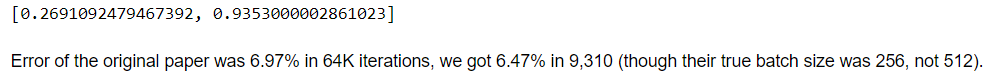

Setting, $9,310 \approx 10000 * 512 / 50000 \approx 100$ epochs

First try to train model 100 epochs with the constant learning rate 0.1 and lr decay at 60, 80. 90

## constant learning rate

In [ ]:

batch_size = args.batch_size
args.epochs = 100
args.lr = 0.1
args.sch = 'constant'
args.blr = args.elr = 0.0001
optimizer = torch.optim.SGD(net.parameters(), args.lr, momentum=0.9, weight_decay=1e-4)

if args.sch == 'constant':
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 80, 90], gamma=0.1)
else:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, steps_per_epoch=len(train_loader), epochs=args.epochs,
                                                    anneal_strategy='linear', div_factor=int(args.lr / args.blr),
                                                    final_div_factor=int(args.lr / args.elr))
num_epochs = args.epochs

criterion = nn.CrossEntropyLoss()
print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(args.lr))
print('| Optimizer = ' + optimizer.__class__.__name__)


elapsed_time = 0
new_lr = args.lr
constant_acc_list = []
constant_loss_list = []
for epoch in range(num_epochs):
    start_time = time.time()
    train(epoch)
    if args.sch == 'constant': scheduler.step()
    acc, loss = test(epoch)
    constant_acc_list.append(acc)
    constant_loss_list.append(loss)
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' % get_hms(elapsed_time))

print('\n[Phase 4] : Testing model')

plt.plot(np.arange(num_epochs), constant_acc_list, label='Accuracy')
plt.show()
plt.close()
plt.plot(np.arange(num_epochs), constant_loss_list, label='Loss')
plt.show()
plt.close()


[Phase 3] : Training model
| Training Epochs = 100
| Initial Learning Rate = 0.1
| Optimizer = SGD

=> Training Epoch #0
| Epoch [  0/100] Iter[  1/ 98]		Loss: 2.6287 Acc@1: 8.008%

| Validation Epoch #0			Loss: 1.9334 Acc@1: 29.86%
| Elapsed time : 0:00:36

=> Training Epoch #1
| Epoch [  1/100] Iter[  1/ 98]		Loss: 1.6935 Acc@1: 33.789%

| Validation Epoch #1			Loss: 1.4656 Acc@1: 45.97%
| Elapsed time : 0:01:11

=> Training Epoch #2
| Epoch [  2/100] Iter[  1/ 98]		Loss: 1.4709 Acc@1: 44.727%

| Validation Epoch #2			Loss: 1.3678 Acc@1: 53.64%
| Elapsed time : 0:01:46

=> Training Epoch #3
| Epoch [  3/100] Iter[  1/ 98]		Loss: 1.2121 Acc@1: 55.859%

| Validation Epoch #3			Loss: 1.2021 Acc@1: 57.00%
| Elapsed time : 0:02:21

=> Training Epoch #4
| Epoch [  4/100] Iter[  1/ 98]		Loss: 1.1395 Acc@1: 56.641%

| Validation Epoch #4			Loss: 1.3412 Acc@1: 55.18%
| Elapsed time : 0:02:56

=> Training Epoch #5
| Epoch [  5/100] Iter[  1/ 98]		Loss: 0.9351 Acc@1: 66.406%

| Validation Epoc

Conclusion:

The baseline is incorrect. 9000 iterations\90 epochs will achieve 93.6% with a constant and decay learning rate scheduler!

## OneCycleLR

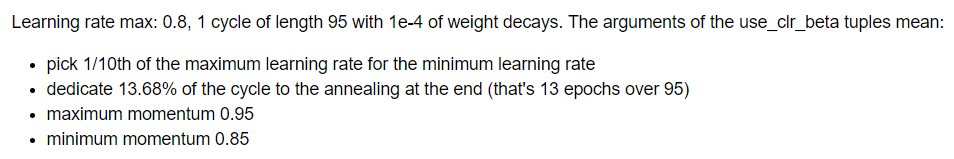

maximum lr 0.8, minimum lr 0.08 as the begin/base learning rate, final learning rate  use a very small value

Try to use 20 epochs(20% of 100 epochs, not 100 epochs in the repo) OneCycleLR

In [ ]:

batch_size = args.batch_size
args.epochs = 20
args.lr = 0.8
args.sch = 'sch'
args.blr = 0.08
args.elr = 0.0001

optimizer = torch.optim.SGD(net.parameters(), 0.1, momentum=0.9, weight_decay=1e-4)

if args.sch == 'constant':
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 80, 90], gamma=0.1)
else:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, steps_per_epoch=len(train_loader), epochs=args.epochs,
                                                    anneal_strategy='linear', div_factor=int(args.lr / args.blr),
                                                    final_div_factor=int(args.lr / args.elr))
num_epochs = args.epochs

criterion = nn.CrossEntropyLoss()
print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(args.lr))
print('| Optimizer = ' + optimizer.__class__.__name__)


elapsed_time = 0
new_lr = args.lr
acc_list = []
loss_list = []
for epoch in range(num_epochs):
    start_time = time.time()
    train(epoch)
    if args.sch == 'constant': scheduler.step()
    acc, loss = test(epoch)
    acc_list.append(acc)
    loss_list.append(loss)
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' % get_hms(elapsed_time))

print('\n[Phase 4] : Testing model')

plt.plot(np.arange(num_epochs), acc_list, label='Accuracy')
plt.show()
plt.close()
plt.plot(np.arange(num_epochs), loss_list, label='Loss')
plt.show()
plt.close()

In [ ]:

plt.plot(np.arange(20), acc_list, label='CLR Accuracy')
plt.plot(np.arange(100), constant_acc_list, label='PC Accuracy')
plt.legend()
plt.show()
plt.close()

plt.plot(np.arange(20), loss_list, label='CLR Loss')
plt.plot(np.arange(100), constant_loss_list, label='PC Loss')
plt.legend()
plt.show()
plt.close()
